In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
from annoy import AnnoyIndex
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-query-product-search/query_150k.csv
/kaggle/input/amazon-query-product-search/product_150k.csv
/kaggle/input/amazon-query-product-search/shopping_queries_dataset_products.parquet
/kaggle/input/amazon-query-product-search/dataset_350k.csv
/kaggle/input/amazon-query-product-search/shopping_queries_dataset_sources.csv
/kaggle/input/amazon-query-product-search/dataset_150k.csv
/kaggle/input/amazon-query-product-search/shopping_queries_dataset_examples.parquet
/kaggle/input/amazon-query-product-search/Dataset.csv
/kaggle/input/amazon-query-product-search/Images/two-tower-model-architecture.png
/kaggle/input/amazon-query-product-search/Images/two-tower-model-architecture-implemented.png


In [2]:
!cp /kaggle/input/amazon-query-product-search/Images/*.png .

<font style="font-size:18px;color:blue;font-style: italic;" >
We will train on 150k records dataset
</font>

In [3]:
df_product_embedding = pd.merge(
    pd.read_csv('/kaggle/input/amazon-query-product-search/product_150k.csv'),
    pd.read_parquet('/kaggle/input/amazon-query-product-search/shopping_queries_dataset_products.parquet')[['product_id','product_title']].drop_duplicates(),
    on = ['product_id']
).reset_index(drop=True)

df_product_embedding['pid'] = range(0, df_product_embedding.shape[0])

df_query_embedding = pd.read_csv('/kaggle/input/amazon-query-product-search/query_150k.csv')
df_query_embedding['qid'] = range(0, df_query_embedding.shape[0])

In [4]:
df_query_embedding.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q24,q25,q26,q27,q28,q29,q30,q31,query,qid
0,0.016756,-0.072765,0.010259,0.048307,0.074665,0.084850,0.022835,-0.066671,0.039883,-0.027148,...,0.011363,0.015675,0.018649,0.025668,0.000701,-0.006060,-0.078536,-0.026082,child proof cabinet locks,0
1,-0.007341,-0.010955,0.059960,0.071282,0.022258,0.032136,0.042009,-0.041242,-0.009459,-0.017514,...,-0.014555,-0.002024,0.062305,0.020665,-0.005689,0.032699,-0.045051,-0.096923,ankle stockings for women sheer,1
2,0.027613,0.019582,-0.032154,0.018755,0.037383,-0.025616,0.024898,-0.025434,-0.047236,0.022970,...,-0.007898,-0.011111,0.059078,0.020216,0.017000,-0.034270,-0.007410,-0.026015,gluten free snacks,2
3,0.021799,-0.018171,0.005133,0.049379,0.021239,-0.004974,0.022700,-0.024240,-0.014328,0.018335,...,0.003084,-0.041141,0.033879,-0.002729,-0.015864,0.026388,-0.021622,-0.083685,hair geow,3
4,0.036940,-0.077912,-0.036468,0.036546,0.121124,0.009458,0.050458,-0.060216,-0.033329,-0.018182,...,0.049342,0.031401,0.065255,0.086359,-0.056535,-0.013196,-0.023676,-0.070366,"1 by one, amplified, outdoor hdtv antenna",4


In [5]:
df_product_embedding.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p153,p154,p155,p156,p157,p158,p159,product_id,product_title,pid
0,0.057728,0.011255,-0.023404,0.092429,-0.020029,0.018735,0.003974,0.008556,-0.005657,0.016547,...,0.006825,0.076608,-0.019186,-0.010564,0.000239,-0.043817,-0.097729,B01A5DU2TA,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler",0
1,0.038126,0.004931,-0.022067,0.066682,0.009379,0.017764,0.019343,0.039371,0.001445,0.010448,...,0.021710,0.093479,-0.026546,-0.052332,0.004328,-0.019683,-0.112607,B07346RPKN,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child",1
2,0.036354,0.016651,0.012105,0.096476,0.024649,-0.013194,0.018663,0.024827,-0.021811,-0.019258,...,0.026384,0.075618,0.015224,-0.049442,0.055570,-0.058420,-0.071863,B078TCVZ4V,Outee Rubber Kids Rain Boots,2
3,0.046325,0.016477,-0.022943,0.018492,-0.025954,-0.005175,0.018342,0.041428,-0.006838,-0.008621,...,0.021611,0.051968,-0.002022,-0.055210,0.022411,-0.055057,-0.084781,B07BR3PPDR,Hope & Henry Girls' Red Milano Stitch Cardigan,3
4,0.042861,-0.012059,-0.051115,0.127641,0.026230,0.011335,0.004991,0.008443,0.037345,-0.019857,...,0.021611,0.051968,-0.002022,-0.055210,0.022411,-0.055057,-0.084781,B07H5C4P19,Spring&Gege Youth Solid Full Zipper Hoodies Soft Kids Hooded Sweatshirt for Boys and Girls Size 3-4 Years Red,4


In [6]:
print(df_query_embedding.shape, df_product_embedding.shape)

(70756, 34) (147673, 163)


<font style="font-size:18px;color:blue;font-style: italic;" >
<ul>
<li>Before training the model, let's check the quality of dataset & input embeddings.
<li>We can run ANN search for queries and ANN search for products to see whether semantic/text closeness is captured in the  embedddings or not
<li> Also dot product between query & product embeddings is not possible as both are in different dimensions.
</font>

In [7]:
query_tower_input_dim = 32
product_tower_input_dim = (32*5)

query_tower_input_dim, product_tower_input_dim

(32, 160)

In [8]:
q = AnnoyIndex(query_tower_input_dim, 'euclidean')
mp_query_dict = {}

for ix,row in df_query_embedding.iterrows():
    mp_query_dict[row['qid']] = row['query']
    
    key = int(row['qid'])
    vec = list(row[['q'+str(x) for x in list(range(query_tower_input_dim))]])
    q.add_item(key,vec)

In [9]:
q.build(100) # 100 trees
q.save('query.tree')


q = AnnoyIndex(query_tower_input_dim,  'euclidean')
q.load('query.tree')

True

In [10]:
top_k = 20
mat = []
for ix,row in df_query_embedding.iterrows():
    item = row['query']
    mat.append([item] + [mp_query_dict[x] for x in q.get_nns_by_item(row['qid'], top_k+1)[1:]])
    
    if ix == 50:
        break
    
cols = ['query_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors1 = pd.DataFrame(mat, columns = cols)

display(df_neighbors1.head(50))

['query_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,query_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,child proof cabinet locks,child locks for cabinets,cabinet locks,cabinet handles,magnetic child safety cabinet locks,lockable tool bag,ring cleaning pen,kids safety locks for cabinets,latch hook kits,electromagnetic door lock,...,surelock luggage lock,infant floor pad,baby safety locks for cabinets,baby proofing cabinet lock bows,cabinet lock,childrens kitchen set,door child lock,kitchen sink hose attachment,gingham door mat,shower garden hose wand
1,ankle stockings for women sheer,cargo pants for men,short cowboy booties for women,pants for women,dress boots for men,waist chains for women,pencil skirts for women,socks long for women,work boots for men,striped panties for women,...,underwear for men,cat boots for men,dropcloths,cargo pants for women,back slit shirts for women,striped dresses for women,slippers for men,socks for booties women,skirts for women,tan skirts for women
2,gluten free snacks,gluten free lemon cookie,heartland gluten free pasta,vegan jerky,gluten free bread,cereals sugar free,beneful wet dog food,chewy granola bars,lays hot pickle,pickled food,...,ezekiel english muffins raisin,chocolate covered raisins,smart tart,wrinkle reducing cream,jerky without sugar,gluten free stuffing mix,beef jerky,miltons gluten free crackers,yung gravy,bleaching cream
3,hair geow,arhletic sweatshirts,pink earrinfs,snoogle,mypillow sheets,sheepjes yarn,dr browns bottles,furinno,ziploc,dr browns nipples,...,gillie suit,calligrpahy,crocs,maraschino cherries,lacross boots men rubber,kill suit gillie,blue wif,timberlans,flairpens,bendy
4,"1 by one, amplified, outdoor hdtv antenna",lighting wired headphones,lego 14 years and up,1/3 amber mist bottles without fist mist sprayers,1 ear wired headphones without mic,lume deodoant for private parts,1.25 drain popper without overflow,over the ear headphones charging dock,bar set without shaker,know it all wine,...,11. he y treverse matts,unplugged wedding sign,now or laters candy,"laser, self-leveling, 3-beam",(hearing aid not amplifer),wired noise cancelling headphones without deep bass,clinique happy for men,deodorant for men gel,1$xrphone cases,cheap vinyl records under 15 dollars
5,adidas sweats slim,fila sweatpants,galaxy adidas shoes men,adidas pants men slim,adidas soccer cleats black,adidas pants men,adidas soccer cleats,adidas superstar all white,adidas beanie,adidas pants,...,adidas sweatband,mens russell sweatpants,adidas running shoes mens,billie eilish hoodie,adidas shoes men,running jacket women adidas,adidas original superstar women,adidas mens shoes samba,adidas mens sweatpants,adidas pants women
6,beta sitosterol now,help the beatles mps,hempcrete,liw hisyamine probiotic,zervos,dr dans cortibalm lip balm,amzcool,crystal bags to hold crystals,graco modes to grow,altavoz jbl,...,cool wallet gocci collors,didlo vibarator sex,credit card tool wallet multitool,lansinoh therapearl 3-in-1 hot or cold breast therapy pack,bathing suit surong women,testalize,zometool,kiss i gloo,duplo,methlypro
7,iphone 11 pro,ipad pro 11,ipad pro,screen protector iphone 8,apple ipad pro 11,apple iphone 11 pro unlocked,screen protector iphone 6s,iphone 11 accessories,ipad pro screen protector 11,screen protector iphone x,...,apple iphone 8 case,phone case iphone 8,iphone 11 pro max,phone screen protector iphone 7,iphone xr cases,apple ipad pro,phone case iphone 6,wireless controller ipad pro,iphone 6s,apple iphone 7 case
8,large training pads for dogs,dog beds for large dogs,dog costumes for large dogs,pet beds for large dogs,dog harness for large dogs,water bowls for large dogs,dog clothes for large dogs,mats for exercise,extra large dog beds for german shepherds,shock collar for 2 dogs,...,food bowls for small dogs,dog belly bands for male dogs,camera for monitoring dog,250 lb resist

In [11]:
print(df_product_embedding.shape)

df_product_embedding.head()

(147673, 163)


,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p153,p154,p155,p156,p157,p158,p159,product_id,product_title,pid
0,0.057728,0.011255,-0.023404,0.092429,-0.020029,0.018735,0.003974,0.008556,-0.005657,0.016547,...,0.006825,0.076608,-0.019186,-0.010564,0.000239,-0.043817,-0.097729,B01A5DU2TA,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler",0
1,0.038126,0.004931,-0.022067,0.066682,0.009379,0.017764,0.019343,0.039371,0.001445,0.010448,...,0.021710,0.093479,-0.026546,-0.052332,0.004328,-0.019683,-0.112607,B07346RPKN,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child",1
2,0.036354,0.016651,0.012105,0.096476,0.024649,-0.013194,0.018663,0.024827,-0.021811,-0.019258,...,0.026384,0.075618,0.015224,-0.049442,0.055570,-0.058420,-0.071863,B078TCVZ4V,Outee Rubber Kids Rain Boots,2
3,0.046325,0.016477,-0.022943,0.018492,-0.025954,-0.005175,0.018342,0.041428,-0.006838,-0.008621,...,0.021611,0.051968,-0.002022,-0.055210,0.022411,-0.055057,-0.084781,B07BR3PPDR,Hope & Henry Girls' Red Milano Stitch Cardigan,3
4,0.042861,-0.012059,-0.051115,0.127641,0.026230,0.011335,0.004991,0.008443,0.037345,-0.019857,...,0.021611,0.051968,-0.002022,-0.055210,0.022411,-0.055057,-0.084781,B07H5C4P19,Spring&Gege Youth Solid Full Zipper Hoodies Soft Kids Hooded Sweatshirt for Boys and Girls Size 3-4 Years Red,4


In [12]:
p = AnnoyIndex(product_tower_input_dim, 'euclidean')
mp_product_dict = {}

for ix,row in df_product_embedding.iterrows():
    mp_product_dict[int(row['pid'])] = row['product_title']
    
    key = int(row['pid'])
    vec = list(row[['p'+str(x) for x in list(range(product_tower_input_dim))]])
    
#     print(key,vec)
    p.add_item(key,vec)

In [13]:
p.build(100) # 100 trees
p.save('product.tree')


p = AnnoyIndex(product_tower_input_dim,  'euclidean')
p.load('product.tree')

True

In [14]:
len(mp_product_dict.items())

147673

In [15]:
top_k = 20
mat = []
for ix,row in df_product_embedding.iterrows():
    item = row['product_title']
    mat.append([item] + [mp_product_dict[x] for x in p.get_nns_by_item(row['pid'], top_k+1)[1:]])
    
    if ix == 50:
        break
    
cols = ['product_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors2 = pd.DataFrame(mat, columns = cols)

display(df_neighbors2.head(50))

['product_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,product_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler","Crocs Kids' Handle It Rain Boots , Candy Pink, 12 Little Kid","Crocs Kids' Classic Clog , Black, 9 Toddler","Crocs Kids' Handle It Rain Boots , Navy, 9 Toddler","Crocs Kids' Crocband Clog , Party Pink, 11 Little Kid","Crocs Kids' Handle It Rain Boots , Navy, 7 Toddler","Crocs Kids' Crocband Clog , Party Pink, 13 Little Kid","Crocs Kids' Classic Clog , Pink Lemonade, 4 Toddler","Crocs Kids' Unicorn Clog, Ballerina Pink/New Mint, 2 Little Kid","Crocs Kids' Handle It Rain Boots , Navy, 12 Little Kid",...,"Crocs Kids' Classic Clog , Lavender, 7 Toddler","Crocs Kids' Classic Clog , Lavender, 3 Little Kid","Crocs Kids' Classic Clog , Lavender, 4 Toddler","Crocs Kids' Classic Clog , Lavender, 5 Big Kid","Crocs Girls' Isabella Sandal Preschool Flat, paradise pink, 12 M US Little Kid","Crocs Crocband Sandal Kids Unisex Niños Sandalias, Azul (Navy/Red), 27/28 EU","Crocs Kids' Crocband Sandal, Navy/Red, 10 M US Toddler","Crocs Kids' Classic Glitter Clog , Black, 10 Toddler","Crocs Unisex Men's and Women's Classic Clog, Electric Pink, 6 US","crocs Bump It Rain Boot (Toddler/Little Kid), Candy Pink/Oyster, 3 M US Little Kid"
1,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child","Hatley unisex child Classic Boots Raincoat, Navy & Yellow, 2 US Youth","Hatley Girls' Toddler Printed Rain Boot, Navy & White Hearts, 6 US Child","Westcott Classic Kids Scissors, Blunt Tip, 5 Inch, Neon Pink (15967)","Merrell Kids' Unisex M-Bare Steps H20 Water Shoe, Pink, 6 Medium US Toddler","Bloch Dance Bunnyhop Ballet Slipper (Toddler/Little Kid) Little Kid (4-8 Years), Pink - 12 B US Little Kid","Plano Fusion Bow Case, Pink, Small","Bloch Dance Bunnyhop Ballet Slipper (Toddler/Little Kid) Little Kid (4-8 Years), Pink - 11 C US Little Kid","Bloch Women's Performa Dance Shoe, Theatrical Pink, 7","Capezio Daisy 205 Ballet Shoe (Toddler/Little Kid),Ballet Pink,9 M US Toddler",...,"Capezio Daisy 205 Ballet Shoe (Toddler/Little Kid),Ballet Pink,7 M US Toddler","Clarks Women's Lafley Krissy Espadrille Wedge Sandal, Black/Suede Leather Combi, 110 M US","Clarks Women's Deva Bell Heeled Sandal, Olive Suede, 090 M US",Pink Motocross Motorcycle Goggles Dirt Bike ATV Racing Mx Goggles for Men Women Youth Kids (C42),"Capezio Little Girls' Hold & Stretch Footed Tight, Ballet Pink, Small","Capezio Daisy 205 Ballet Shoe (Toddler/Little Kid),Ballet Pink,9.5 M US Toddler","Avery Durable View 3 Ring Binder, 1 Inch Slant Rings, 1 Pink Binder (17830)",WINGHOUSE X Minnie 3D Bow Round Crossbody Mini (My First) Purse Small Cross Bag with Adjustable Shoulder Strap for Kids Little Girls (2-4Y),"Clarks womens Sillian Paz Slip On Loafer, Black Synthetic Nubuck, 9.5 US","Merrell womens Siren Edge 3 Hiking Shoe, Navy/Wave, 8.5 US"
2,Outee Rubber Kids Rain Boots,HDE Womens Rainbow Striped Retro Fashion Dolphin Running Workout Shorts (White),"Utopia Towels 100 Pack Commercial Shop Towels - Cleaning Rags, White",Tankee Slip - Black - Large-DD,AWAYTR Realistic Printed Butterfly Hair Clip 12Pcs Fairy Hair Clips Set Hair Accessories for Girls Women (Purple),Dansko Professional Women Mules & Clogs Shoes White Box Size 40,Expression Tees Womens Keep Calm Plants Have Protein Vegetarian T-Shirt Small Maroon,Nike Jumpman Premium 9A1640-681 Laptop Bookbag Basketball Boys Backpack - Gym Red,VIPKID Orange Teaching T-Shirt (Unisex) (L),Reebok Men's Shoes Legacy Lifter II Black Orange Flare True Grey 8 Size 10,...,WAVERLY Sweet Things Spa Fabric Shower Curtain,"PaddleTek Element Pickleball Paddle, ProPolyCore Honeycomb Composite (red)",Stance Gamut II Super Invisible Sock Large White 3 Pack,"eclife 24"" Black Bathroom Vanities Set (Contemporary/T03 B02)",SoB Flowerpot Treeman Baby Groot Succulent Planter Cute Green Plan

In [16]:
# del p
# del q

In [17]:
import gc
gc.collect()

8

In [18]:
df_dataset = pd.merge(pd.read_csv('/kaggle/input/amazon-query-product-search/dataset_150k.csv'), 
                      df_product_embedding[['product_id','product_title']].drop_duplicates(), on = ['product_id']
                     )

print(df_dataset.shape)
# df_dataset = df_dataset[df_dataset.split != 'generated']
df_dataset.head()

(157097, 197)


,query,product_id,esci_label,split,q0,q1,q2,q3,q4,q5,...,p151,p152,p153,p154,p155,p156,p157,p158,p159,product_title
0,monogram crossbody bags for women,B07SC67L97,E,train,0.007149,-0.036234,-0.021769,0.071798,0.004489,0.046100,...,0.009924,0.015074,0.014845,0.030969,-0.002622,-0.004156,-0.004414,-0.052931,-0.062627,Tommy Hilfiger Jacquard Crossbody Purse With Monogram (Beige)
1,monogram crossbody bags for women,B088BMKTVZ,E,train,0.007149,-0.036234,-0.021769,0.071798,0.004489,0.046100,...,0.022348,0.072437,0.017069,0.044085,0.034383,-0.037070,-0.031683,-0.046816,-0.130665,Montana West Leather Cowhide Tote Bag For Women Western Fringe Handbag Shoulder Bag With Matching Wallet (Z-Coffee3)
2,monogram crossbody bags for women,B07NVTDGVN,E,train,0.007149,-0.036234,-0.021769,0.071798,0.004489,0.046100,...,-0.007226,0.030359,0.017682,0.054370,-0.040309,-0.028475,0.002260,-0.008909,-0.113362,"Tory Burch Women's Gemini Link Canvas Mini Bag, Black, One Size"
3,replicia tory burch bags,B07NVTDGVN,E,train,-0.010582,-0.032959,-0.027428,0.031883,-0.000479,0.062785,...,-0.007226,0.030359,0.017682,0.054370,-0.040309,-0.028475,0.002260,-0.008909,-0.113362,"Tory Burch Women's Gemini Link Canvas Mini Bag, Black, One Size"
4,green advertine crystal,B07H8GJ44Q,E,train,0.025034,-0.025958,-0.021118,0.026299,0.006780,0.022166,...,0.011845,0.031754,0.026041,0.061598,-0.041917,-0.050758,0.015715,-0.050046,-0.078058,"Crystal Glass Diamond Shaped Decoration, Green 60mm Jewel Paperweight,Gift Decoration Idea For Christmas, Thanksgiving (Please identify our brand Yarr Store)"


In [19]:
df_dataset.shape

(157097, 197)

In [20]:
df_dataset.esci_label.value_counts()

esci_label
E    79252
I    77845
Name: count, dtype: int64

In [21]:
df_dataset[df_dataset.esci_label == 'E'][['query','product_title','split']].sample(20)

,query,product_title,split
68400,root touch up blonde ),"Clairol Root Touch-Up by Nice'n Easy Permanent Hair Dye, 7 Dark Blonde Hair Color, 2 Count",train
4727,small electric dryer,"AMI PARTS WE1M964 Timer Knob with Metal Ring for General Electric Dryer,Replaces 1811122 AP4980845 PS3487132(2 PCS)",train
142345,coffee grinders,"Cuisinart Coffee Grinder, 12 Cup Capacity, BLACK",train
149918,pregnacy jackets,"Sweet Mommy Maternity Pregnancy Baby Carrier Babywearing Multifunctional Mod's Coat Removable Panel Mocha, LL",train
83739,day hike backpack,"SHARKMOUTH Hiking Hydration Backpack Pack with 2.5L BPA Free Water Bladder, Roomy and Comfortable for long Day Hikes, Day Trips, Daypack travel and Journey, LightGray",train
148298,moroccanoil,"Moroccanoil Treatment Light Hair Oil, 3.4 oz",train
40376,iphone 11 clear,MAXKU iPhone 11ケースと互換性があり、6.1インチのクリアショックアブソーバーケース,train
107300,airforce 1 men shoes,Nike Mens Air Force 1 '07 LV8 CW6999 600 Triple Red - Size 10,train
120643,cabbage patch dolls,"Cabbage Patch Kids Cuties Collection, Parker the Puppy Cutie Baby Doll",train
46053,get well package,"Get Well Gift Box Basket - For Cold/Flu/Illness - Over 2.5 Pounds of Care, Concern, and Love - Great Care Package - Send a Smile Today!",train


In [22]:
df_dataset[df_dataset.esci_label == 'I'][['query','product_title','split']].sample(20)

,query,product_title,split
54726,planers woodworking,Medley Hills Farm Alum Granulated Powder (Food Grade) 3.5 lbs.,generated
50437,lu cookies,HaokHome 96020-1 Modern Stripe Peel and Stick Wallpaper Herringbone Black White Vinyl Self Adhesive Decorative 17.7in x 9.8ft,generated
17643,l curl lashes,"Ambesonne Mandala Shower Curtain, Wedding Invitation Card Theme Lace Mandala and Place for Text Art Print, Cloth Fabric Bathroom Decor Set with Hooks, 84"" Long Extra, Sky Blue",generated
131613,lily pad highchair cover,Floral Non-Slip Carpet pad Rose Petals Sakura Lily Flowers Blooms Romance Florets Design Home Colored Floor mats 6.5'x7.8' Pale Pink Yellow Fern Green,train
138436,lacy panty backs,"OPI GelColor, You've Got that Glas-glow, Nude Gel Nail Polish, Scotland Collection, 0.5 fl oz",generated
32513,private label sneaker bag,2PCS Bed Risers Furniture Riser Heavy Duty Bed Lifts in Heights of 4Inches (add Height 5cm),generated
47870,matt paint,"Fabric Paint Set, Shuttle Art 45 Colors 3D Permanent Paint with Brushes Palette Fabric Pen Fabric Sheet Stencils, Glow in The Dark, Glitter,Metallic Colors for Textile Fabric T-shirt Jeans Glass",train
146528,boys white dress top,"Revlon ColorStay Eyebrow Pencil with Spoolie Brush, Waterproof, Longwearing, Angled Tip Applicator for Perfect Brows, Soft Brown (210)",generated
72290,3x polo shirts for men big and tall,GO GEAR SC-BEI Console (Beige),generated
45315,reading floor lamps with adjustable gooseneck led,Dominion: Renaissance,generated


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import transformers
from keras.utils.vis_utils import plot_model

In [24]:
print([p for p in df_product_embedding.columns])

print([p for p in df_query_embedding.columns])

['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99', 'p100', 'p101', 'p102', 'p103', 'p104', 'p105', 'p106', 'p107', 'p108', 'p109', 'p110', 'p111', 'p112', 'p113', 'p114', 'p115', 'p116', 'p117', 'p118', 'p119', 'p120', 'p121', 'p122', 'p123', 'p124', 'p125', 'p126', 'p127', 'p128', 'p129', 'p130', 'p131', 'p132', 'p133', 'p134', 'p135', 'p136', 'p137', 'p138

<font style="font-size:18px;color:blue;font-style: italic;" >
Train set can have generated negative samples but validation or test-set is true data-distribution/examples.
</font>

In [25]:
# Convert 'esci_label' column to binary labels
df_dataset['binary_label'] = df_dataset['esci_label'].apply(lambda x: 1 if x == 'E' else 0)

# Split the dataset into training and validation
train_data = df_dataset[df_dataset['split'] != 'test']
val_data = df_dataset[df_dataset['split'] == 'test']

train_labels = np.array(train_data['binary_label'])
val_labels = np.array(val_data['binary_label'])

train_labels = train_labels.astype('float32')
val_labels = val_labels.astype('float32')



print(train_data.esci_label.value_counts(),
      val_data.esci_label.value_counts())

query_tower_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 
                                  'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 
                                  'q17', 'q18', 'q19', 'q20', 'q21', 'q22', 'q23', 'q24', 
                                  'q25', 'q26', 'q27', 'q28', 'q29', 'q30', 'q31']

product_tower_cols = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10',
                      'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20',
                      'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30',
                      'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
                      'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50',
                      'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60',
                      'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70',
                      'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80',
                      'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90',
                      'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99', 'p100',
                      'p101', 'p102', 'p103', 'p104', 'p105', 'p106', 'p107', 'p108', 'p109', 'p110',
                      'p111', 'p112', 'p113', 'p114', 'p115', 'p116', 'p117', 'p118', 'p119', 'p120',
                      'p121', 'p122', 'p123', 'p124', 'p125', 'p126', 'p127', 'p128', 'p129', 'p130',
                      'p131', 'p132', 'p133', 'p134', 'p135', 'p136', 'p137', 'p138', 'p139', 'p140',
                      'p141', 'p142', 'p143', 'p144', 'p145', 'p146', 'p147', 'p148', 'p149', 'p150',
                      'p151', 'p152', 'p153', 'p154', 'p155', 'p156', 'p157', 'p158', 'p159'
                     ]



# Prepare input data for training and validation
train_inputs = [
    np.array(train_data[query_tower_cols]),
    
    np.array(train_data[product_tower_cols])
    
]

val_inputs = [
    np.array(val_data[query_tower_cols]),
    
    np.array(val_data[product_tower_cols])
]

esci_label
I    75124
E    61682
Name: count, dtype: int64 esci_label
E    17570
I     2721
Name: count, dtype: int64


In [26]:
import gc

# Explicitly collect garbage (may not free up all memory)
gc.collect()

233

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Flatten, Dot, Reshape, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint



import keras.backend as K
from keras.layers import Input, Dense, Embedding, Flatten, Lambda
from keras.models import Model
import numpy as np
import torch

<font style="font-size:18px;color:blue;font-style: italic;" >
Query & Product dimensions are different
</font>

In [28]:
print(query_tower_input_dim, product_tower_input_dim)


32 160


<font style="font-size:18px;color:blue;font-style: italic;" >
An ideal Two-tower model architecture for Product Search
</font>
<img src="two-tower-model-architecture.png">

<font style="font-size:18px;color:blue;font-style: italic;" >
Two-tower model architecture for Product Search we implemented as per the availability of the data.
</font>
<img src="two-tower-model-architecture-implemented.png">

In [29]:
import tensorflow as tf
from keras.layers import Input, Dense, Dot, Lambda
from keras.models import Model
from keras import backend as K


embedding_dim = 16


# Input layers for tokenized sequences
input_query = Input(shape=(query_tower_input_dim,), name='input_query')
final_query_embedding = Dense(embedding_dim, activation='linear', name='embedding_layer_query')(input_query)
normalized_query = Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=-1), name='normalize_query')(final_query_embedding)

input_product = Input(shape=(product_tower_input_dim,), name='input_product')
final_product_embedding = Dense(embedding_dim, activation='linear', name='embedding_layer_product')(input_product)
normalized_product = Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=-1), name='normalize_product')(final_product_embedding)

cosine_similarity = Dot(axes=1, normalize=True, name='cosine_similarity')([normalized_product, normalized_query])

# Build your model
model = Model(inputs=[input_query, input_product], outputs=cosine_similarity)


# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_product (InputLayer)     [(None, 160)]        0           []                               
                                                                                                  
 input_query (InputLayer)       [(None, 32)]         0           []                               
                                                                                                  
 embedding_layer_product (Dense  (None, 16)          2576        ['input_product[0][0]']          
 )                                                                                                
                                                                                                  
 embedding_layer_query (Dense)  (None, 16)           528         ['input_query[0][0]']        

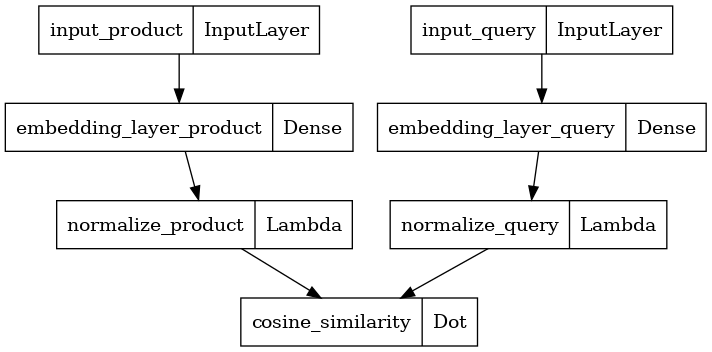

In [30]:
plot_model(model)

In [31]:
#Have not used it 
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print("Classes: ",np.unique(train_labels))
print("Class weights: ",class_weights)


Classes:  [0. 1.]
Class weights:  [0.91053458 1.1089621 ]


In [32]:
# Define a model checkpoint callback to save the best model weights during training
checkpoint_path = 'best_model_weights.h5'  # Specify the path to save the best model
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',  # Monitor validation loss
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Minimize the validation loss
)

# Compile the model with 'binary_crossentropy' loss as a string
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])


# Fit the model with model checkpoint callback
history = model.fit(
    # Training data and parameters
    train_inputs, train_labels, epochs=100, batch_size=64, 
    validation_data=(val_inputs, val_labels),
    callbacks=[model_checkpoint],
#     class_weight=dict(enumerate(class_weights))
    # Giving positive class more importance to positive labels to ensure precision is high.
    class_weight=dict(enumerate([1,2]))
                   )


Epoch 1/100
2124/2138 [============================>.] - ETA: 0s - loss: 0.8389 - accuracy: 0.6219
Epoch 1: val_loss improved from inf to 0.51747, saving model to best_model_weights.h5
2138/2138 [==============================] - 9s 4ms/step - loss: 0.8378 - accuracy: 0.6226 - val_loss: 0.5175 - val_accuracy: 0.7927
Epoch 2/100
2134/2138 [============================>.] - ETA: 0s - loss: 0.7113 - accuracy: 0.7163
Epoch 2: val_loss did not improve from 0.51747
2138/2138 [==============================] - 7s 3ms/step - loss: 0.7115 - accuracy: 0.7163 - val_loss: 0.5473 - val_accuracy: 0.7757
Epoch 3/100
2127/2138 [============================>.] - ETA: 0s - loss: 0.7025 - accuracy: 0.7206
Epoch 3: val_loss improved from 0.51747 to 0.50739, saving model to best_model_weights.h5
2138/2138 [==============================] - 7s 3ms/step - loss: 0.7026 - accuracy: 0.7208 - val_loss: 0.5074 - val_accuracy: 0.7989
Epoch 4/100
2136/2138 [============================>.] - ETA: 0s - loss: 0.6683 -

In [33]:
# After training, you can load the best model weights using:
model.load_weights(checkpoint_path)

<font style="font-size:18px;color:blue;font-style: italic;" >
Chop-off the product tower & generate/get product embeddings
</font>

In [34]:
product_model = Model(inputs=[input_query, input_product],
                         outputs=model.get_layer('normalize_product').output
                   )

In [35]:

input_data_product = [
    np.array([np.array([0] * query_tower_input_dim)] * df_product_embedding.shape[0]),
    
    np.array(df_product_embedding[product_tower_cols])
    
]

product_embeddings = product_model.predict(input_data_product)
len(product_embeddings)

4615/4615 [==============================] - 7s 1ms/step


147673

In [36]:
df_product_embeddings_model = pd.DataFrame(product_embeddings, columns = [f'p{x}'for x in range(embedding_dim)] )

df_product_embeddings_model['product_id'] = df_product_embedding['product_id']
df_product_embeddings_model['product_title'] = df_product_embedding['product_title']
df_product_embeddings_model['pid'] = df_product_embedding['pid']

df_product_embeddings_model.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,product_id,product_title,pid
0,0.421077,-0.081914,-0.018399,-0.324269,0.055350,0.301110,0.043757,-0.280722,0.149350,0.142256,-0.291971,-0.328770,0.351678,-0.195654,-0.343182,-0.142948,B01A5DU2TA,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler",0
1,0.327389,-0.077227,0.091065,-0.220458,-0.072216,0.439574,0.212059,-0.121436,-0.027922,0.102191,-0.385818,-0.297545,0.310624,-0.301816,-0.299175,-0.214721,B07346RPKN,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child",1
2,0.358717,0.070334,0.036215,-0.255746,-0.036643,0.329540,0.193992,-0.479703,0.042820,-0.119456,-0.299168,-0.199239,0.349281,-0.045418,-0.236070,-0.311258,B078TCVZ4V,Outee Rubber Kids Rain Boots,2
3,0.139965,0.104092,0.082933,-0.264356,0.077782,0.382229,0.047408,-0.311105,0.292073,0.223193,-0.042008,-0.271374,0.240933,-0.424693,-0.408952,-0.159517,B07BR3PPDR,Hope & Henry Girls' Red Milano Stitch Cardigan,3
4,0.337795,0.014722,-0.064972,-0.211749,-0.078706,0.366646,0.331693,-0.199403,0.126627,0.273203,-0.074641,-0.300883,0.331192,-0.331134,-0.365525,-0.080566,B07H5C4P19,Spring&Gege Youth Solid Full Zipper Hoodies Soft Kids Hooded Sweatshirt for Boys and Girls Size 3-4 Years Red,4


<font style="font-size:18px;color:blue;font-style: italic;" >
We can analyse the quality of learnt products embeddings of 16-dimensions by doing an ANN search/similarity search
</font>

In [37]:
# pm = AnnoyIndex(embedding_dim, 'euclidean')
pm = AnnoyIndex(embedding_dim, 'dot')
mp_product_dict = {}

for ix,row in df_product_embeddings_model.iterrows():
    mp_product_dict[int(row['pid'])] = row['product_title']
    
    key = int(row['pid'])
    vec = list(row[['p'+str(x) for x in list(range(embedding_dim))]])
    
#     print(key,vec)
    pm.add_item(key,vec)

In [38]:
pm.build(100) # 100 trees
pm.save('product_model.tree')

# pm = AnnoyIndex(embedding_dim,  'euclidean')
pm = AnnoyIndex(embedding_dim,  'dot')
pm.load('product_model.tree')

True

In [39]:
top_k = 20
mat = []
for ix,row in df_product_embeddings_model.iterrows():
    item = row['product_title']
    mat.append([item] + [mp_product_dict[x] for x in pm.get_nns_by_item(row['pid'], top_k+1)[1:]])
    
    if ix == 50:
        break
    
cols = ['product_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors3 = pd.DataFrame(mat, columns = cols)

display(df_neighbors3.head(50))

['product_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,product_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler","Crocs Kids' Handle It Rain Boots , Candy Pink, 12 Little Kid","UGG Unisex-Child Fluff Yeah Slide Slipper, Purple Rainbow, 8 Toddler US","Crocs Kids' Handle It Rain Boots , Cerulean Blue, 11 Little Kid",Boy's 'Ohana in Dark Shadow/Scuba,Barbie Fashionistas Dolls Floral Frills,Knaughty Knickers Daddys Little Cumslut Submissive Oral Slut Black Boyshort DDLG,"Ty Beanie Boos 6"" Wilma, Perfect Plush!","Crocs Kids' Classic Clog , Slate Grey, 4 Big Kid","Crocs Kids' Handle It Rain Boots , Cerulean Blue, 10 Toddler",...,"Gerber Baby Girls' 4 Pack Sleep 'N Play Footie, Cloudy, Newborn","Bearington Baby Dottie Pink Teddy Bear, Baby Rattle, 5""","Crocs Kids' Classic Clog , Bright Cobalt, 4 Toddler","Crocs Kids' Crocband Clog , Lavender/Neon Purple, 9 Toddler","Crocs Kids' Classic Clog , Slate Grey, 3 Little Kid","Crocs Kids' Classic Clog , Lavender, 3 Little Kid","The Children's Place Baby Boys and Toddler Boys Skinny Chino Pants, Flax, 4T",The Children's Place Girls' Side Stripe French Terry Jogger Pants Pink Abalone S (5/6),YAN XUAN Unisex Novelty Crew Tube Socks Funny FUCK OFF Ribbed Knit Socks,"Barbie Dream Horse & Doll, Black Hair"
1,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child","Splash About, Go Splash, Chaleco de natación para niños, Azul (Vintage Moby), 1 - 2 años","Splash About Go Splash Swim Vest, Vintage Moby, 1-2 Years",Brisco Brands Crawl Walk Fish Funny Fishing New Parents Gifts Cute Baby Onesie Bodysuit Navy 6 Months,Vans Infants/Toddlers Authentic Skate Shoes 5 Infants US,Feetly Fun Socks for Men Cool Socks Space Socks 4-Pack Funny Mens Socks Funky Zodiac Sign Stars Planets 8-12 US,Clothful_Clothes 3Pcs Newborn Kids Baby Girls Letter Romper Jumpsuit+Floral Pants Outfits Set,"Wrangler Authentics Boys’ Classic Cargo Pant, olive, 10",Toddler Kids Baby Girl Watermelon Letter Print Tops + Shorts Outfits Set Clothes,"The Children's Place boys Pull On Cargo Pants, Night Camo, 10",...,Littleforbig Cotton Romper Onesie Pajamas Bodysuit - Dinosaurs Baseball Reglan Sleeves XL,"Disney baby boys Mickey Mouse 5 Pack Shorty Socks, Assorted Blue, 24-36 Months US","Native Shoes Baby Jefferson Print Child Sneaker, Regatta Blue/Shell White/Stars/Stripes, 10 Medium US Toddler",Nautica Kids Youth Athletic Fashion Sneaker Running Shoe Slip On- Boy - Girl Little Kid Big Kid-Canvey Youth-Red Solid Size-4,This Is My Christmas Pajama Shirt Funny Christmas T Shirts,"Little Me Unisex Baby 2 Piece Footie and Cap, Welcome World, White, Newborn",I Love Dump Truck Shirt | Little Boys Kids T-Shirt Gift,"Columbia Kids' Buga II Suit, Black/Grill, 18-24 Months","Columbia Baby Toddler Kids Double Trouble Jacket, Grape Gum/Grape Gum Reindeer, 4T","ALLNTRENDS Adult Hoodie Stanger Monster Trending Tops Cool Fans Gift Popular (S, Black)"
2,Outee Rubber Kids Rain Boots,Balanced Co. Prison Mike Dress Socks Michael Scott Funny Socks Crazy Socks Casual Cotton Crew Socks (Black/Gray),Crappie Fishing Retro Panfish Fisherman T-Shirt,Nickelodeon JoJo Siwa Rain Boots - Size 8 Toddler,Unisex Fun Novelty Crazy Crew Socks Gun American Flag Dress Socks,Volleyball Woven Mid-Calf Socks | Classic Ball | White & Black,"Good Luck Sock Men's School of Fish Socks, Big & Tall",Stetson Rawlins Pigskin Baseball Cap Men Grey One Size,Jumping Beans Little Boys' 4-12 Star Wars Trooper Tee 7 Charcoal Snow,"N'Ice Caps Boys Authentic Constructed Big Brother Embroidered Ball Cap (2-3yrs, Big Brother)",...,"CafePress Star Trek Dammit Jim Baseball Jersey Cotton Baseball Jersey, 3/4 Raglan Sleeve Shirt Red/White",Jumping Beans Little Girls' 4-12 Captain Marvel Stars Tee 6 Turquoise,"Koloa Surf Co. Colorful Tie-Dye T-Shirt, XL",Soluo Men's Novelty Funny Crazy Socks Funky Crew Sock Cool Colorful Cotton C

In [40]:
gc.collect()

3383

<font style="font-size:18px;color:blue;font-style: italic;" >
Chop-off the query tower & generate/get query embeddings
</font>

In [41]:
query_model = Model(inputs=[input_query, input_product],
                         outputs=model.get_layer('normalize_query').output
                   )

In [42]:
input_data_query = [
    
    np.array(df_query_embedding[query_tower_cols]),
    np.array([np.array([0] * product_tower_input_dim)] * df_query_embedding.shape[0]),
    
]


query_embeddings = query_model.predict(input_data_query)
len(query_embeddings)

2212/2212 [==============================] - 3s 2ms/step


70756

In [43]:
df_query_embeddings_model = pd.DataFrame(query_embeddings, columns = [f'q{x}'for x in range(embedding_dim)] )

df_query_embeddings_model['query'] = df_query_embedding['query']
df_query_embeddings_model['qid'] = df_query_embedding['qid']

df_query_embeddings_model.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,query,qid
0,0.404391,-0.577082,-0.324322,-0.039441,0.089913,0.174614,0.076517,0.235005,-0.293832,-0.101019,-0.132265,0.055763,0.170229,-0.356564,0.149925,-0.036170,child proof cabinet locks,0
1,0.159966,0.196946,-0.033470,0.012126,-0.083155,0.652303,0.176047,-0.148117,-0.090036,0.153370,0.164160,-0.039155,0.337836,-0.134814,-0.430533,0.266895,ankle stockings for women sheer,1
2,0.537063,-0.085737,-0.369991,-0.149729,0.303551,0.072453,0.080648,-0.073411,-0.380999,-0.092636,-0.390061,-0.338637,0.028876,0.067262,-0.022793,-0.095777,gluten free snacks,2
3,0.408021,0.123808,-0.191755,-0.089226,0.053604,0.454818,-0.016997,-0.226189,-0.137777,-0.088752,-0.145713,-0.586745,0.171786,-0.145453,-0.250048,-0.081993,hair geow,3
4,0.106331,-0.122428,-0.443914,0.005620,0.207285,-0.267122,0.077540,0.027762,-0.245043,-0.088107,-0.098765,0.069705,0.206557,-0.655649,-0.271813,0.163288,"1 by one, amplified, outdoor hdtv antenna",4


<font style="font-size:18px;color:blue;font-style: italic;" >
We can analyse the quality of learnt query embeddings of 16-dimensions by doing an ANN search/similarity search
</font>

In [44]:
from annoy import AnnoyIndex
# qm = AnnoyIndex(embedding_dim, 'euclidean')
qm = AnnoyIndex(embedding_dim, 'dot')
mp_query_dict = {}

for ix,row in df_query_embeddings_model.iterrows():
    mp_query_dict[row['qid']] = row['query']
    
    key = int(row['qid'])
    vec = list(row[['q'+str(x) for x in list(range(embedding_dim))]])
    
#     print(key,vec)
    qm.add_item(key,vec)

In [45]:
qm.build(100) # 100 trees
qm.save('query_model.tree')

# qm = AnnoyIndex(embedding_dim,  'euclidean')
qm = AnnoyIndex(embedding_dim,  'dot')
qm.load('query_model.tree')

True

In [46]:
top_k = 20
mat = []
for ix,row in df_query_embeddings_model.iterrows():
    item = row['query']
    mat.append([item] + [mp_query_dict[x] for x in qm.get_nns_by_item(row['qid'], top_k+1)[1:]])
    
    if ix == 50:
        break
    
cols = ['query_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors4 = pd.DataFrame(mat, columns = cols)

display(df_neighbors4.head(50))

['query_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,query_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,child proof cabinet locks,child locks for cabinets,cabinet handles,cabinet locks,kitchen gadget gifts,gingham door mat,magnetic child safety cabinet locks,kids safety locks for cabinets,decorativeletter opener,turn in box classroom,...,child safety locks without screws,digger toys for boys,baby proofing cabinet lock bows,door child lock,fruit and vegetable keepers,novelty bottle opener,master lock door,nursery organizer,guitar nut,safes with lock and key
1,ankle stockings for women sheer,womens riding boots,knee high boots for women,brown high boots for women,womens learher skirt brown,women hiking boots,spider jackets for men,womens gloves with fur lining,off shoulder sweatshirt for women,short boots for women,...,shirt and cape women,wide leg pants women,leg length jackets for women,white fabric belts for women,fr cargo work pants for men,leopard tops for men,womens winter nightgowns,mid calf boots for women,plus size knee high stockings for women,oneil white short sleeve rash guard women
2,gluten free snacks,wrinkle reducing cream,vegetable flakes for soup,miltons gluten free crackers,gluten free lemon cookie,papaya enzymes chewable,jerky without sugar,sugar in the raw,raw peanuts without skin,seasoning shaker,...,dried ginger slices,gluten free sugar free candy,jewlery cleaner precious,sprinkles are for cupcakes not toilet seats,vegetable peeler,cut gloves food,tomato soup,toffee nut syrup,white chocolate peppermint bark,frezer dried fruit slices
3,hair geow,mypillow sheets,japonesque sponges,wig caps for women brown,plumeria hair clip,oopo reno 2,maraschino cherries,loomis,laird mushroom,howies yellow pro grip hockey tape,...,winter oofos,fishkars scissors,cold weatherface mask,boreal cleaner,spoozie booster pads,pockeys sticks matcha,snow blower ariens,nipple suckers,ski face mask men,shoeless joe ballgloves
4,"1 by one, amplified, outdoor hdtv antenna",engaged champagne flutes,par lighting for stage,1 set of earbuds without microphone,#68 do not fuplicate key,the future is curly,h11 led fog bulb dual color,gaming headset #1,12v 4.0ah rechargeable battery,chrome chandelier,...,show your mood without saying a word,all lights fleece for gm,fart glass bombs,hitachi magic wand rechargeable,1 ear wired headphones without mic,led under cabinet lighting,gender reveal smoke bombs,07 cadillac escalade headlights without ballest,led name badge,its a beautiful day to save life wine tumbler
5,adidas sweats slim,adidas pants boys,adidas pants,adidas mens shoes samba,toby keith greatest hits cd,katy perry,adidas running shoes mens,adidas shoes,adidas mens shoes,adidas streetwear shoes,...,adidas tennis skirt,badass ben thompson,adidas superstar all white,adidas pants men,paris hilton heiress perfume,galaxy adidas shoes men,drew house justin bieber,bare essentials makeup,girls adidas sweatshirt,mens ultraboost adidas
6,beta sitosterol now,visbiome,mtn dewzero,dentastix,citrisafe,pacsafe,bacitracin,ez carafe,hunger,paco rabanne 1 million,...,chemex,obagi clenziderm acne,ropa erótica,enyzme,thrivecausemetic,working with winston,magnatiles,thermos carafe,hempcrete,l cetrulline
7,iphone 11 pro,clear phone case iphone xr,phone cases iphone 7,phone cases iphone 6s,phone case iphone x,case for iphone 7,athletic cases iphone xr,screen protector iphone x,phone cases for iphone 8,red case iphone 7,...,smart watch for iphone 8,case for iphone 6,iphone external storage,apple ipad 9.7 case,phone case iphone 6,privacy screen iphone xr,phone screen protector iphone 7,iphone 7 case lv,screen protector iphone 6s,red clear iphone 8 plus case
8,large training pads for dogs,dog tracker,grooming glove dog,hebrew nationalhot dogs,10 exercise ball,10 foot dog leashes for large dogs,dog carrier medium dogs,working dog harness,fitbark dog activity 

<font style="font-size:18px;color:blue;font-style: italic;" >
Random Chat-Gpt Queries for an ecommerce website
</font>

In [47]:
product_search_queries = [
    "Red dress for a wedding",
    "Best laptop under $1000",
    "Nike running shoes for women",
    "iPhone 13 reviews",
    "Men's winter jackets on sale",
    "Top-rated kitchen appliances",
    "Summer dresses for women",
    "Samsung TV specifications",
    "Gift ideas for anniversary",
    "XYZ brand headphones",
    "Women's shoes size 8",
    "Deals on smartphones",
    "Men's formal suits",
    "Fitness trackers with heart rate monitor",
    "Digital cameras with 4K video",
    "Wireless gaming mouse",
    "Outdoor camping gear",
    "Bluetooth earbuds under $50",
    "Designer handbags on clearance",
    "Gaming laptops with RTX graphics",
    "Organic skincare products",
    "Smartphones with long battery life",
    "Running shoes for flat feet",
    "Laptop deals for students",
    "Wireless noise-canceling headphones",
    "Digital cameras for beginners",
    "Best coffee makers under $50",
    "Latest fashion trends for summer",
    "Top-rated gaming keyboards",
    "Dining room furniture sets",
    "Winter coats for kids",
    "Men's watches with leather straps",
    "Home gym equipment for small spaces",
    "Women's handbags on sale",
    "Bluetooth speakers with waterproof features",
    "Outdoor patio furniture",
    "Affordable fitness trackers",
    "Cookware sets for induction cooktops",
    "Portable chargers for smartphones",
    "Desktop computers for gaming",
]
product_search_queries

['Red dress for a wedding',
 'Best laptop under $1000',
 'Nike running shoes for women',
 'iPhone 13 reviews',
 "Men's winter jackets on sale",
 'Top-rated kitchen appliances',
 'Summer dresses for women',
 'Samsung TV specifications',
 'Gift ideas for anniversary',
 'XYZ brand headphones',
 "Women's shoes size 8",
 'Deals on smartphones',
 "Men's formal suits",
 'Fitness trackers with heart rate monitor',
 'Digital cameras with 4K video',
 'Wireless gaming mouse',
 'Outdoor camping gear',
 'Bluetooth earbuds under $50',
 'Designer handbags on clearance',
 'Gaming laptops with RTX graphics',
 'Organic skincare products',
 'Smartphones with long battery life',
 'Running shoes for flat feet',
 'Laptop deals for students',
 'Wireless noise-canceling headphones',
 'Digital cameras for beginners',
 'Best coffee makers under $50',
 'Latest fashion trends for summer',
 'Top-rated gaming keyboards',
 'Dining room furniture sets',
 'Winter coats for kids',
 "Men's watches with leather straps",


In [48]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=20ba6e86267c52c655dc0e92124d6f4ad45835977cba8d05267ca0144abf67f1
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [49]:
gc.collect()

761

In [50]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained model (you can choose from various models like BERT, RoBERTa, etc.)
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model_sentence_transformers = SentenceTransformer('distilbert-base-uncased')

In [51]:
gc.collect()

258

In [52]:
import numpy as np

def reshape_array(input_array, d):
    k, _ = input_array.shape
    new_array = np.zeros((k, d))
    
    for i in range(k):
        for j in range(d):
            start_idx = j * (768 // d)
            end_idx = (j + 1) * (768 // d) if j < (d - 1) else 768
            chunk = input_array[i, start_idx:end_idx]
            new_array[i, j] = np.mean(chunk)
    
    return new_array

In [53]:
query_max_words = 10
product_title_max_words = 50
product_description_max_words = 20
product_bullet_point_max_words = 50
product_brand_max_words = 5
product_color_max_words = 5

In [54]:
query_dim = 32

cols = ['q' + str(x) for x in list(range(0, query_dim))] + ['query']

sentences = product_search_queries

sentence_embeddings = model_sentence_transformers.encode(sentences, convert_to_tensor=True)

sentence_embeddings = reshape_array(sentence_embeddings.cpu().numpy(), query_dim)
    
df_query_test_actual = pd.DataFrame(sentence_embeddings)

df_query_test_actual.columns = query_tower_cols
df_query_test_actual['query'] = product_search_queries

df_query_test_actual.head(10)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q23,q24,q25,q26,q27,q28,q29,q30,q31,query
0,0.007695,-0.021772,0.009272,0.036473,0.036392,0.060426,0.082609,-0.006833,0.016331,-0.013605,...,-0.001767,-0.001836,0.064187,0.051783,0.101478,-0.119302,0.049785,-0.006160,-0.138378,Red dress for a wedding
1,0.024959,-0.056813,0.012811,0.066770,0.009723,0.108941,0.046452,-0.025799,-0.043453,-0.001607,...,-0.017166,0.006947,-0.051148,0.049090,0.126767,-0.059563,0.013806,0.032236,-0.070560,Best laptop under $1000
2,0.033188,-0.024257,0.013281,0.082233,-0.008739,0.029180,0.058220,-0.004041,-0.022621,-0.033982,...,-0.046140,0.026808,0.000927,0.035232,0.086720,-0.023257,0.078713,-0.027420,-0.102153,Nike running shoes for women
3,0.056923,-0.067703,0.009689,0.091970,0.006944,0.019842,0.127488,-0.077576,-0.012539,-0.052159,...,-0.023747,0.049304,0.036855,0.059732,0.080127,-0.067598,0.001987,-0.016549,-0.140160,iPhone 13 reviews
4,-0.002794,-0.014394,0.002074,0.103217,0.008246,0.021852,0.033978,0.043218,0.010377,-0.027439,...,-0.038056,0.033847,0.061088,0.030497,0.068912,-0.026625,0.050694,-0.053367,-0.147220,Men's winter jackets on sale
5,0.040239,-0.038390,0.033297,0.043152,0.006269,0.070937,0.060673,0.007826,-0.028447,-0.007493,...,-0.046024,0.027945,0.028276,0.006050,0.069759,-0.048874,0.024739,0.002231,-0.094185,Top-rated kitchen appliances
6,-0.008644,-0.082387,0.036484,0.055468,0.017954,0.019735,0.072948,-0.034080,0.000498,-0.027001,...,-0.002020,0.040031,0.038441,0.044322,0.073868,-0.009448,0.048376,-0.015863,-0.162779,Summer dresses for women
7,0.008620,-0.028510,-0.004212,0.076861,0.006605,0.041094,0.035000,-0.081250,-0.033778,-0.054816,...,-0.060133,0.051974,0.043357,0.061763,0.052355,-0.025444,0.012203,0.057285,-0.115468,Samsung TV specifications
8,0.001529,-0.079384,0.015710,0.027016,0.001537,0.002226,0.050695,-0.082849,0.032851,-0.024570,...,0.022764,0.032034,0.078213,0.056186,0.103443,-0.021040,0.024876,-0.039867,-0.079636,Gift ideas for anniversary
9,0.094642,-0.051391,-0.085842,0.080198,0.045319,0.002039,0.019717,-0.037467,-0.037722,-0.037470,...,-0.002823,0.038923,0.053937,0.098513,0.057621,-0.022579,-0.013432,0.048429,-0.072693,XYZ brand headphones


In [55]:
sentence_embeddings

array([[ 0.00769546, -0.02177239,  0.00927221, ...,  0.04978519,
        -0.00616005, -0.13837807],
       [ 0.02495866, -0.05681255,  0.01281075, ...,  0.01380571,
         0.03223628, -0.07056033],
       [ 0.03318826, -0.0242566 ,  0.01328102, ...,  0.07871263,
        -0.02741987, -0.10215303],
       ...,
       [ 0.01275667, -0.02846041, -0.00055769, ...,  0.02364927,
        -0.03687379, -0.05787027],
       [ 0.02474625, -0.06099543, -0.00739887, ...,  0.01515812,
         0.05502471, -0.15908162],
       [-0.02238438, -0.05318382,  0.02165482, ..., -0.01916119,
         0.04019103, -0.13263924]])

In [56]:
input_data_query = [
    
    np.array(df_query_test_actual[query_tower_cols]),
    np.array([np.array([0] * product_tower_input_dim)] * df_query_test_actual.shape[0]),
    
]


query_embeddings = query_model.predict(input_data_query)
len(query_embeddings)

2/2 [==============================] - 0s 4ms/step


40

In [57]:
len(query_embeddings)

40

In [58]:
cols = [f'q{x}'for x in range(embedding_dim)]

df_query_test = pd.DataFrame(query_embeddings, columns = cols)
df_query_test['query'] = product_search_queries

df_query_test.head(50)

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,query
0,0.189861,0.224041,-0.159182,-0.280289,0.003804,0.105407,0.359072,-0.114424,0.079442,0.040850,-0.114137,-0.048437,0.299420,-0.451034,-0.554513,0.181069,Red dress for a wedding
1,0.064849,-0.089086,-0.279676,-0.281408,0.160559,0.002348,-0.308802,0.192256,-0.308827,0.242449,0.230608,0.089948,-0.072154,-0.412072,-0.416058,0.329853,Best laptop under $1000
2,0.127695,0.173267,0.150916,0.051533,-0.199212,0.467424,-0.012497,-0.173618,0.019532,0.111440,0.178193,-0.368191,0.166795,-0.426688,-0.464512,0.184389,Nike running shoes for women
3,0.335746,-0.003710,-0.150698,-0.092645,-0.041267,-0.022201,0.233611,-0.013998,-0.032941,0.287080,0.234776,-0.064105,0.021798,-0.468567,-0.488319,0.444733,iPhone 13 reviews
4,0.015442,0.160554,0.047026,-0.011882,-0.078321,0.575599,0.337715,-0.247121,0.090712,0.070252,0.053557,-0.329913,0.405197,-0.054823,-0.380075,0.150134,Men's winter jackets on sale
5,0.260015,-0.026054,-0.143468,-0.262468,0.360179,0.106183,-0.050666,0.108349,-0.215228,-0.359202,-0.318548,-0.310199,0.048652,-0.404697,-0.198049,0.329416,Top-rated kitchen appliances
6,0.120309,0.016336,0.017546,-0.010634,-0.101485,0.477047,0.359193,-0.071856,0.063829,0.221990,-0.013578,-0.069764,0.310756,-0.403407,-0.465295,0.280304,Summer dresses for women
7,0.135917,-0.042642,-0.240622,-0.181474,-0.001875,-0.126084,0.092310,0.092324,-0.079936,0.440145,0.336225,-0.009492,0.055593,-0.280156,-0.603108,0.312024,Samsung TV specifications
8,0.548765,-0.411894,-0.227892,-0.107694,-0.163419,-0.042060,0.253196,0.131183,-0.181167,-0.002102,-0.273440,0.063371,0.151930,-0.224592,-0.406075,0.076441,Gift ideas for anniversary
9,0.321767,-0.137206,-0.312168,-0.162058,0.135734,-0.371882,-0.100982,-0.047987,-0.159075,0.274838,0.167499,-0.391219,-0.002042,-0.456163,-0.305736,0.034589,XYZ brand headphones


In [59]:
results = []
top_k = 20

desc = []
for i in range(top_k):
    desc.append(f'product_title_{(i+1)}')
desc = ['query'] + desc

for ix,row in df_query_test.iterrows():
    qvec = [f'q{x}' for x in list(range(embedding_dim))]
    qvec = row[qvec]
    similar_vector_ids,similar_distances = pm.get_nns_by_vector(qvec, top_k, include_distances=True)

#     print(similar_vector_ids, similar_distances)

    similar_vector_product_title = [mp_product_dict[x] for x in similar_vector_ids]
    results.append([row['query']] + similar_vector_product_title)

df_results = pd.DataFrame(results, columns =  desc)

df_results.head(50)

,query,product_title_1,product_title_2,product_title_3,product_title_4,product_title_5,product_title_6,product_title_7,product_title_8,product_title_9,...,product_title_11,product_title_12,product_title_13,product_title_14,product_title_15,product_title_16,product_title_17,product_title_18,product_title_19,product_title_20
0,Red dress for a wedding,Heread 1920s Bride Wedding Birdcage Veil White Crystal Bridal Headpiece Accessories with Comb for Women and Girls,Yanstar Handmade Crystal Bridal Belts Sashes Navy Blue Wedding Belt With Rhinestones For Wedding Bridesmaid Dress (Silver-Navy),"Premium NEW ~GOLD GOLF KING'S CREST~ METAL BLAZER BUTTON SET ~ 14-Piece Set of Shank Style Fashion Buttons For Double Breasted Blazers, Sport Coats, Jackets & Uniforms ~","Aofur Womens Evening Dress Ball Gown Prom Party Wedding Formal Long Chiffon Maxi Dresses Plus Size (XXXX-Large, White)",Bridal Veil Women's Simple Tulle Short Wedding Veil Ribbon Edge with Comb for Wedding Bachelorette Party (White),Fdesigner Bride Cathedral Veil Wedding Chapel Veils Bridal Headpieces Statement Veils Long Soft Veil with Comb 2T (White),WeddingBobDIY 12Pieces/lot Groom Boutonniere Wedding Silk Rose(3.5cm) Flowers Accessories Prom Pin Man Suit Decoration Purple,Toddler Girl's Embroidery Tulle Lace Maxi Flower Girl Wedding Bridesmaid Dress 3/4 Sleeve Long A Line Pageant Formal Prom Dance Evening Gowns Casual Holiday Party Dress Royal Blue 5-6,Deluxe Mens Toga Costume Standard,...,"ALICEPUB Chiffon Burgundy Bridesmaid Dresses Wine Long Formal Party Dress for Women Special Occasion Halter, US10",GARGALA Wedding Garters for Bride Bridal Lace Garters Set White Garter Size Optional (M),"Lace Applique 3D Beaded Embroidered Floral Rhinestone Trim Patches Great for DIY Neckline Bodice Wedding Bridal Prom Dress A2AB (A, Gold)","Miusol Women's Formal Floral Lace Wedding Bridesmaid Maxi Dress (Medium, Dark Green)","Aofur Womens V Neck Chiffon Casual Maxi Dress Wedding Evening Gowns Summer Sleeveless A-Line Party Long Skirt (X-Large, Burgundy)",USIX 2pc Pack-Handmade Men's Lapel Artificial Peony Flower Boutonniere Pin for Suit Wedding Groom Groomsmen Brooch Rose Boutonniere (Purple Boutonniere x2),"ToonySume Women's Mother of Bride Groom Dress Pant Suits Three Pieces with Jacket Formal Lace Chiffon Dress for Wedding(US14,Silver Grey)","Women Casual Tea Dresses A Line Swing Vintage Cocktail Dress, Modest Church Formal Dress, Flared Bridesmaid Midi Spring Dress for Party/Graduation/Homecoming/Wedding Guest/Prom Green M",habibee Rhinestone Pre-tied Bow Tie for Men Adjustable Sequin Bow Tie for Wedding and Party Costume Accessories,"Women's Gothic Cosplay Dress Hooded Vintage Medieval Floor Length Renaissance Medieval Costume Dresses Black (Black, X-Large)"
1,Best laptop under $1000,"2 Pack 3.5mm Headphones Jack Adapter,Aux Cable Headphone Converter Accessories Compatible with phone11/Xs MAX/XR/X/8/8 P/7/pad/pod Support Plug and Play/os 13","Short Lighting Cable,FEEL2NICE 10 Pack 7-Inch iPhone Cord Data Sync USB Portable Fast Charger for iPhone X XS Max XR / 8/8 Plus / 7/7 Plus / 6/6 Plus / 5S / iPad/iPod, White","Anker iPhone Charger Cable, Powerline II Lightning Cable (10ft), Durable Cable, MFi Certified for iPhone X / 8/8 Plus /7/7 Plus / 6/6 Plus / 5s (White), iPad 8, and More",Anker iPhone充電ケーブル PowerLine II ライトニングケーブル MFi認証 超高耐久 iPhone 13 / 13 Pro / 12 / SE(第2世代) / iPad 各種対応 (3.0m ホワイト),"[2-Pack] Galaxy S9 Black Screen Protector,[3D Curved] [Anti-Scratch][High Definition] Tempered Glass Screen Protector Compatible with Samsung Galaxy S9(NOT S9 Plus)","USB Wall Charger, Charger Adapter, AILKIN 2-Pack 2.1Amp Dual Port Quick Charger Plug Cube for iPhone SE/11 Pro Max/8/7/6S/6S Plus/6 Plus/6, Samsung Galaxy S7/S6/S5 Edge, LG, HTC, Huawei, Moto, Kindle","Long iPhone Charger 10ft, CABEPOW 2Pack 10 Feet Lightning Cable, Data Sync Fast iPhone USB Charging Cable Cord for iPhone Xs/XS Max/XR/X / 8/8 Plus / 7/7 Plus / 6/6 Plus / 5s and More (Black)","USB Charger, Anker Elite Dual Po

<font style="font-size:18px;color:blue;font-style: italic;" >
<ul>
<li> One can create even bigger dataset to fine tune embeddings for more accurate results.
<li> In real business/production usecase, more useful numerical features around the two towers can be added.
<li> I encourage people to pick this up, modify, upgrade the architecture, use more sophisticated techniques like Adaptive-Mimic Mechanism (AMM) & Category Alignment Loss (CAL) one we saw in other videos. Or use learnings of some other papers/ideas to better it.
</font>